## Introduction
Semantic textual similarity deals with determining how similar a pair of text documents are. The goal of the first task is to implement a new architecture by combining the ideas from papers
- Siamese Recurrent Architectures for Learning Sentence Similarity, Jonas Mueller et. al (will be referred as the AAAI paper)
- A Structured Self-Attentive Sentence Embedding, Zhouhan Lin et. al (will be referred as the ICLR paper) <br/><br/>
Furthermore, you'd be evaluating whether the new architecture improves the results of **Siamese Recurrent Architectures for Learning Sentence Similarity, Jonas Mueller et. al**. Your overall network architecture should look similar to the following figure. 
![Untitled%20Diagram.drawio%20%281%29.png](https://raw.githubusercontent.com/shahrukhx01/ocr-test/main/download.png)
<br/><br/>


Moreover, you'd be required to implement further helper functions that these papers propose i.e., attention penalty term for loss, etc.

### SICK dataset
We will use SICK dataset throughout the project (at least in the first two tasks). To get more information about the dataset you can refer to the original [paper](http://www.lrec-conf.org/proceedings/lrec2014/pdf/363_Paper.pdf) on the dataset. You can download the dataset using one of the following links:
- [dataset page 1](https://marcobaroni.org/composes/sick.html)
- [dataset page 2](https://huggingface.co/datasets/sick)    

The relevant columns for the project are `sentence_A`, `sentence_B`, `relatedness_score`, where `relatedness_score` is the label. <br><br>
**Hint: For each task make sure to decide whether the label should be normalized or not.**<br><br>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from test import evaluate_test_set
import sts_data
from importlib import reload

2022-02-12 22:14:05.534795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-12 22:14:05.534824: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Part 1. Data pipeline (3 points)
Before starting working on the model, we must configure the data pipeline to load the data in the correct format. Please, implement the functions for processing the data.

### Part 1.1 Loading and preprocessing the data (1 point)
Download the SICK dataset and store it in [pandas](https://pandas.pydata.org/docs/index.html) `Dataframe`'s. You should use the official data split.  

Implement `load_data` method of `STSData` class in `sts_data.py`. The method must download the dataset and perform basic preprocessing. Minimal preprocessing required:  
1. normalize text to lower case
2. remove punctuations  
3. remove [stopwords](https://en.wikipedia.org/wiki/Stop_word) - we provided you with the list of English stopwords.
4. Optionally, any other preprocessing that you deem necessary.

All the preprocessing code must be contained in the `preprocessing.py` file.  
You can use Hugginface's [datasets library](https://huggingface.co/docs/datasets/) for easy dataset download.

### Part 1.2 Building vocabulary (1 point)
Before we can feed our text to the model it must be vectorized. We use 300 dimensional pretrained [FastText embeddings](https://fasttext.cc/docs/en/english-vectors.html) for mapping words to vectors. To know more general information about embeddings you can refer to [this video](https://www.youtube.com/watch?v=ERibwqs9p38) (even though, we use different types of embeddings - FastText vs Word2Vec described in the video - the general purpose of them is the same).  
In order to apply the embedding, we must first construct the vocabulary for data. Complete the `create_vocab` method of `STSData` class in `sts_data.py` where you concatenate each sentence pair, tokenize it and construct the vocabulary for the whole training data. You should use [torchtext](https://torchtext.readthedocs.io/en/latest/data.html
) for processing the data. For tokenization, you can use any library (or write your own tokenizer), but we recommend you to use tokenizer by [spacy](https://spacy.io/). Use the `fasttext.simple.300d` as pretrained vectors.  
In the end, you must have a vocabulary object capable of mapping your input to corresponding vectors. Remember that the vocabulary is created using only training data (not touching validation or test data).

### Part 1.3 Creating DataLoader (1 point)
Implement `get_data_loader` method of `STSData` class in `sts_data.py`. It must perform the following operations on each of the data splits:
1. vectorize each pair of the sentences by replacing all tokens with their index in vocabulary
2. normalize labels
3. convert everything to PyTorch tensors
4. pad every sentence so that all of them have the same length
5. create `STSDataset` from `dataset.py`
6. create PyTorch DataLoader out of the created dataset. 


We have provided you with the interfaces of possible helper functions, but you can change them as you need.   
In the end, you must have 3 data loaders for each of the splits.

In [3]:
reload(sts_data)
from sts_data import STSData

columns_mapping = {
        "sent1": "sentence_A",
        "sent2": "sentence_B",
        "label": "relatedness_score",
    }
dataset_name = "sick"
sick_data = STSData(
    dataset_name=dataset_name,
    columns_mapping=columns_mapping,
    normalize_labels=True,
    normalization_const=5.0,
)
batch_size = 64
sick_dataloaders = sick_data.get_data_loader(batch_size=batch_size)

INFO:root:loading and preprocessing data...


Dataset sick downloaded and prepared to /home/ibrahimssd/.cache/huggingface/datasets/sick/default/0.0.0/c6b3b0b44eb84b134851396d6d464e5cb8f026960519d640e087fe33472626db. Subsequent calls will reuse this data.


INFO:root:reading and preprocessing data completed...
INFO:root:creating vocabulary...
INFO:torchtext.vocab:Loading vectors from .vector_cache/wiki.simple.vec.pt
INFO:root:creating vocabulary completed...


In [4]:
sick_dataloaders

(<torch.utils.data.dataloader.DataLoader at 0x7f4cac693090>,
 <torch.utils.data.dataloader.DataLoader at 0x7f4cac6937d0>)

## Part 2. Model Configuration & Hyperparameter Tuning (3 points)
In this part, you are required to define a model capable of learning self-attentive sentence embeddings described in [this ICLR paper](https://arxiv.org/pdf/1703.03130.pdf). The sentence embedding learned by this model will be used for computing the similarity score instead of the simpler embeddings described in the original AAAI paper.  
Please familiarize yourself with the model described in the ICLR paper and implement `SiameseBiLSTMAttention` and `SelfAttention` classes in `siamese_lstm_attention.py`. Remember that you must run the model on each sentence in the sentence pair to calculate the similarity between them. You can use `similarity_score` from `utils.py` to compute the similarity score between two sentences. 
  
To get more theoretical information about attention mechanisms you can refer to [this chapter](https://web.stanford.edu/~jurafsky/slp3/10.pdf) of ["Speech and Language Processing" book](https://web.stanford.edu/~jurafsky/slp3/) by Dan Jurafsky and James H. Martin, where the attention mechanism is described in the context of the machine translation task. 

Finally, once your implementation works on the default parameters stated below, make sure to perform **hyperparameter tuning** to find the best combination of hyperparameters.

In [5]:
output_size = 1
hidden_size = 128
vocab_size = len(sick_data.vocab)
embedding_size = 300
embedding_weights = sick_data.vocab.vectors
lstm_layers = 4
learning_rate = 1e-1
fc_hidden_size = 64
max_epochs = 5
bidirectional = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## self attention config
self_attention_config = {
    "hidden_size": 150,  ## refers to variable 'da' in the ICLR paper
    "output_size": 20,  ## refers to variable 'r' in the ICLR paper
    "penalty": 0.0,  ## refers to penalty coefficient term in the ICLR paper
}

In [6]:
## init siamese lstm

from siamese_lstm_attention import SiameseBiLSTMAttention

siamese_lstm_attention = SiameseBiLSTMAttention(
    batch_size=batch_size,
    output_size=output_size,
    hidden_size=hidden_size,
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    embedding_weights=embedding_weights,
    lstm_layers=lstm_layers,
    self_attention_config=self_attention_config,
    fc_hidden_size=fc_hidden_size,
    device=device,
    bidirectional=bidirectional,
)

optimizer = torch.optim.Adam(params=siamese_lstm_attention.parameters())
## move model to device
siamese_lstm_attention.to(device)

SiameseBiLSTMAttention(
  (embeddings): Embedding(2029, 300)
  (lookup_table): Embedding(2029, 300)
  (bi_lstm): LSTM(300, 128, num_layers=4, batch_first=True, bidirectional=True)
  (SelfAtt): SelfAttention(
    (ws1): Linear(in_features=256, out_features=150, bias=False)
    (ws2): Linear(in_features=150, out_features=20, bias=False)
    (tanh): Tanh()
    (softmax): Softmax(dim=None)
  )
  (fc): Linear(in_features=5120, out_features=64, bias=True)
  (tanh): Tanh()
)

## Part 3. Training (2 points)  
Perform the final training of the model by implementing functions in `train.py` after setting values of your best-chosen hyperparameters. Note you can use the same training function when performing hyperparameter tuning.
- **What is a good choice of performance metric here for evaluating your model?** [Max 2-3 lines]
- **What other performance evaluation metric can we use here for this task? Motivate your answer.**[Max 2-3 lines]

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/5 [00:00<?, ?it/s]/local/home/ibrahimssd/Desktop/UD_Semester_2/NNIT/Updated_NLP (semantic)/nlp_project_nnti/task1/siamese_lstm_attention.py:153: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_matrix = self.softmax(self.ws2(self.tanh(self.ws1(inp))))
INFO:root:Evaluating accuracy on dev set
/local/home/ibrahimssd/Desktop/UD_Semester_2/NNIT/Updated_NLP (semantic)/nlp_project_nnti/task1/siamese_lstm_attention.py:153: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_matrix = self.softmax(self.ws2(self.tanh(self.ws1(inp))))
INFO:root:new model saved
INFO:root:Train loss: 0.09877628087997437 - Train score: -1.310378201624883 -- Validation loss: 0.12069923430681229 - Validation score: -0.6583398056391672
 20%|██        | 1/5 [00:09<00:36,  9.23s/it]

[0/4] train_loss: 0.099, accuracy_score: -1.310


/local/home/ibrahimssd/Desktop/UD_Semester_2/NNIT/Updated_NLP (semantic)/nlp_project_nnti/task1/siamese_lstm_attention.py:153: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_matrix = self.softmax(self.ws2(self.tanh(self.ws1(inp))))
INFO:root:Evaluating accuracy on dev set
/local/home/ibrahimssd/Desktop/UD_Semester_2/NNIT/Updated_NLP (semantic)/nlp_project_nnti/task1/siamese_lstm_attention.py:153: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_matrix = self.softmax(self.ws2(self.tanh(self.ws1(inp))))
INFO:root:Train loss: 0.12100119888782501 - Train score: -0.865880995160974 -- Validation loss: 0.1289117932319641 - Validation score: -0.7789360307013671
 40%|████      | 2/5 [00:18<00:27,  9.27s/it]

[1/4] train_loss: 0.121, accuracy_score: -0.866


/local/home/ibrahimssd/Desktop/UD_Semester_2/NNIT/Updated_NLP (semantic)/nlp_project_nnti/task1/siamese_lstm_attention.py:153: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_matrix = self.softmax(self.ws2(self.tanh(self.ws1(inp))))
INFO:root:Evaluating accuracy on dev set
/local/home/ibrahimssd/Desktop/UD_Semester_2/NNIT/Updated_NLP (semantic)/nlp_project_nnti/task1/siamese_lstm_attention.py:153: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_matrix = self.softmax(self.ws2(self.tanh(self.ws1(inp))))
INFO:root:new model saved
INFO:root:Train loss: 0.08788897842168808 - Train score: -0.5979038212838432 -- Validation loss: 0.10552120953798294 - Validation score: -0.5381816449915646
 60%|██████    | 3/5 [00:28<00:18,  9.37s/it]

[2/4] train_loss: 0.088, accuracy_score: -0.598


/local/home/ibrahimssd/Desktop/UD_Semester_2/NNIT/Updated_NLP (semantic)/nlp_project_nnti/task1/siamese_lstm_attention.py:153: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_matrix = self.softmax(self.ws2(self.tanh(self.ws1(inp))))
INFO:root:Evaluating accuracy on dev set
/local/home/ibrahimssd/Desktop/UD_Semester_2/NNIT/Updated_NLP (semantic)/nlp_project_nnti/task1/siamese_lstm_attention.py:153: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_matrix = self.softmax(self.ws2(self.tanh(self.ws1(inp))))
INFO:root:Train loss: 0.11707521975040436 - Train score: -0.4136567078319704 -- Validation loss: 0.12078050523996353 - Validation score: -1.3581200383744285
 80%|████████  | 4/5 [00:37<00:09,  9.47s/it]

[3/4] train_loss: 0.117, accuracy_score: -0.414


/local/home/ibrahimssd/Desktop/UD_Semester_2/NNIT/Updated_NLP (semantic)/nlp_project_nnti/task1/siamese_lstm_attention.py:153: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_matrix = self.softmax(self.ws2(self.tanh(self.ws1(inp))))
INFO:root:Evaluating accuracy on dev set
/local/home/ibrahimssd/Desktop/UD_Semester_2/NNIT/Updated_NLP (semantic)/nlp_project_nnti/task1/siamese_lstm_attention.py:153: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_matrix = self.softmax(self.ws2(self.tanh(self.ws1(inp))))
INFO:root:Train loss: 0.09004973620176315 - Train score: -0.7104605800638009 -- Validation loss: 0.10917455703020096 - Validation score: -0.828521344923967
100%|██████████| 5/5 [00:46<00:00,  9.38s/it]


[4/4] train_loss: 0.090, accuracy_score: -0.710
Final score: -0.710, expected 1.000


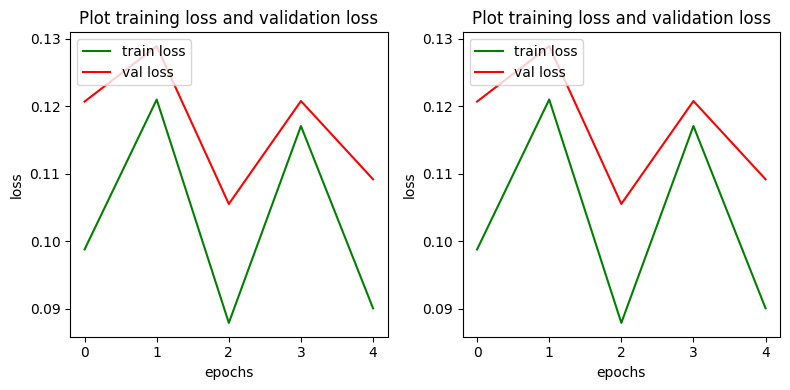

In [8]:
from train import train_model

siamese_lstm_attention = train_model(
    model=siamese_lstm_attention,
    optimizer=optimizer,
    dataloader=sick_dataloaders,
    data=sick_data,
    max_epochs=max_epochs,
    config_dict={
        "device": device,
        "model_name": "siamese_lstm_attention",
        "self_attention_config": self_attention_config,
    },
)

## Part 4. Evaluation and Analysis (2 points)  
Implement function evaluate_test_set to calculate the final accuracy of the performance evaluation metric on the test data.  
Compare the result with the original AAAI paper. Сomment on effect of penalty loss on model capacity. Did the inclusion of the self-attention block improve the results? If yes, then how? Can you think of additional techniques to improve the results? Briefly answer these questions in the markdown cells.

In [ ]:
evaluate_test_set(
    model=siamese_lstm_attention,
    data_loader=sick_dataloaders,
    config_dict={
        "device": device,
        "model_name": "siamese_lstm_attention",
        "self_attention_config": self_attention_config,
    },
)

INFO:root:Evaluating accuracy on test set
/local/home/ibrahimssd/Desktop/UD_Semester_2/NNIT/Updated_NLP (semantic)/nlp_project_nnti/task1/siamese_lstm_attention.py:153: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_matrix = self.softmax(self.ws2(self.tanh(self.ws1(inp))))
